# **World Model - Vision Component (VAE)**

This notebook implements the Vision component of a World Model architecture using a Variational Autoencoder (VAE) approach. We'll train a neural network to learn a compressed latent representation of visual observations from a car racing environment.

## **Project Pipeline**

1. **Create a PyTorch dataset from collected episodes**
2. **Design a Variational Autoencoder (VAE) architecture**
3. **Train the autoencoder with appropriate loss functions**
4. **Visualize reconstructed images and evaluate performance**
5. **Explore the environment with real-time reconstruction**
6. **Analyze the latent space representation**
7. **Visualize the latent space distribution using UMAP**

In [1]:
import h5py
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class CarRacingDataset(Dataset):
    def __init__(self, h5_path='car_racing_data.h5', transform=None):
        self.h5_path = h5_path
        
        self.transform = transform if transform is not None else transforms.ToTensor()
        
        # Open the HDF5 file to retrieve dataset dimensions
        with h5py.File(self.h5_path, 'r') as h5f:
            self.num_episodes, self.max_steps = h5f['images'].shape[:2]
            self.total_frames = self.num_episodes * self.max_steps
    
        self.h5_file = None 
    
    def __len__(self):
        return self.total_frames
    
    def __getitem__(self, idx):
        if self.h5_file is None:
            self.h5_file = h5py.File(self.h5_path, 'r')
        
        # Calculate episode and step from the flat index
        episode = idx // self.max_steps
        step = idx % self.max_steps
        
        # Access the datasets directly using episode and step indices
        image = self.h5_file['images'][episode, step]       
        action = self.h5_file['actions'][episode, step]      
        reward = self.h5_file['rewards'][episode, step]     
        done = self.h5_file['dones'][episode, step]          
        
        # Apply the transform (e.g., ToTensor)
        image = self.transform(image)  # Converts to [C, H, W] and scales to [0, 1]
        
        # Convert action, reward, and done to tensors
        action = torch.tensor(action, dtype=torch.float32)  
        reward = torch.tensor(reward, dtype=torch.float32)  
        done = torch.tensor(done, dtype=torch.float32)     
        
        return image, action, reward, done
    
    def __del__(self):
        if self.h5_file is not None:
            self.h5_file.close()

## **Variational Autoencoder (VAE) Architecture**
---

<img src="imgs/vae.png" width="900"/>

The VAE consists of an encoder that compresses images into a latent distribution, and a decoder that reconstructs images from samples in the latent space.

### **Loss Function**
The VAE is trained using a composite loss function consisting of:
1. **Reconstruction Loss**: Mean Squared Error (MSE) between original and reconstructed images
2. **Kullback-Leibler Divergence**: Regularization term that ensures the latent space approximates a standard normal distribution
   
$$
\mathcal{L}_{total} = \mathcal{L}_{recon} + \beta \cdot \mathcal{L}_{KL}
$$

$$
\mathcal{L}_{KL} = -\frac{1}{2} \sum_{i=1}^{d} \left(1 + \log\sigma_i^2 - \mu_i^2 - \sigma_i^2\right)
$$
Where $\beta$ is a hyperparameter that controls the importance of the KL term.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=32):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            # Input: 3 x 96 x 96
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.Flatten()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256 * 6 * 6, self.latent_dim)
        self.fc_logvar = nn.Linear(256 * 6 * 6, self.latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, 256 * 6 * 6)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 6, 6)),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, recon, x, mu, logvar, beta=2.0):
        batch_size = x.size(0)

        recon_loss = nn.functional.mse_loss(recon, x, reduction='sum') / batch_size
        
        kl_loss = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) / batch_size

         
        total_loss = recon_loss + beta * kl_loss
        
        return total_loss, recon_loss, kl_loss

In [2]:
from torchsummary import summary

# Initialize model and display architecture summary
model = VAE(3, 32).to('cuda')
input_size = (3, 96, 96)  
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]           1,568
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 64, 24, 24]          32,832
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 12, 12]         131,200
              ReLU-6          [-1, 128, 12, 12]               0
            Conv2d-7            [-1, 256, 6, 6]         524,544
              ReLU-8            [-1, 256, 6, 6]               0
           Flatten-9                 [-1, 9216]               0
           Linear-10                   [-1, 32]         294,944
           Linear-11                   [-1, 32]         294,944
           Linear-12                 [-1, 9216]         304,128
        Unflatten-13            [-1, 256, 6, 6]               0
  ConvTranspose2d-14          [-1, 128,

## **Model Training**
 
The function below handles the VAE training process, including:
 - Moving tensors to the appropriate device (GPU/CPU)
 - Progress tracking with tqdm
 - Loss calculation and backpropagation
 - Model checkpointing


In [3]:
from tqdm import tqdm
import os

def train_vae(model, train_loader, optimizer, num_epochs=10, file_name='vae', folder='checkpoints'):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.to(device)
    model.train()
    
    os.makedirs(folder, exist_ok=True)

    for epoch in range(num_epochs):
        train_loss = 0
        model.train()

        with tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for images, actions, rewards, dones in pbar:
                images = images.to(device)
                recon, mu, logvar = model(images.squeeze())
                loss, recon_loss, kl = model.loss(recon, images.squeeze(), mu, logvar)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.set_postfix(loss=f"{loss.item():.4f} | mse: {recon_loss:.4f} | KL: {kl:.4f}")
                
        avg_epoch_loss = train_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_epoch_loss:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{folder}/{file_name}.pth')

### Hyperparameters

 - **Batch Size**: 1024
 - **Latent Space Dimension**: 32
 - **Optimizer**: AdamW
 - **Learning Rate**: 0.001
 - **Weight Decay (L2 Regularization)**: 1e-6
 - **Training Epochs**: 3

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import AdamW

LATENT_SIZE = 32
EPOCHS = 3


dataset = CarRacingDataset(h5_path='car_racing_data_10k.h5')
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=8, pin_memory=True, persistant_workers=True)

model = VAE(3, LATENT_SIZE)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:
%%time
train_vae(model, dataloader, optimizer, num_epochs=EPOCHS, file_name = 'vae', folder='checkpoints')

### **Load Pre-trained Model**


In [3]:
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(3, 32).to(device)
model.load_state_dict(torch.load('checkpoints/vae.pth',weights_only=False))

<All keys matched successfully>


## **Visualization of Image Reconstruction**---

This section demonstrates the VAE's reconstruction capabilities by comparing original images with their reconstructed versions.
- **Image Comparison**: The `plot_images` function displays original images alongside their reconstructed counterparts
- **Random Sampling**: The `test_vae` function selects random images from the dataset and passes them through the VAE


In [12]:
import torch
import matplotlib.pyplot as plt

def plot_images(original, reconstructed, n=4):
    fig, axes = plt.subplots(2, n, figsize=(12, 7))
    
    for i in range(n):
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu().numpy())
        axes[0, i].axis('off')
    axes[0, 0].set_title("Original Image", fontsize=12, fontweight='bold', loc='left')

    for i in range(n):
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0).cpu().detach().numpy())
        axes[1, i].axis('off')
    axes[1, 0].set_title("Reconstructed Images", fontsize=12, fontweight='bold', loc='left')
    plt.tight_layout()
    plt.show()


def test_vae(model, dataset, n=3):
    model.eval() 
    images = next(iter(dataset))[0].to(device).squeeze()  # Get a batch of images
    
    with torch.no_grad(): 
        reconstructed, _, _ = model(images)
    
    indices = torch.randperm(images.size(0))[:n]  # Select random images
    plot_images(images[indices], reconstructed[indices], n)

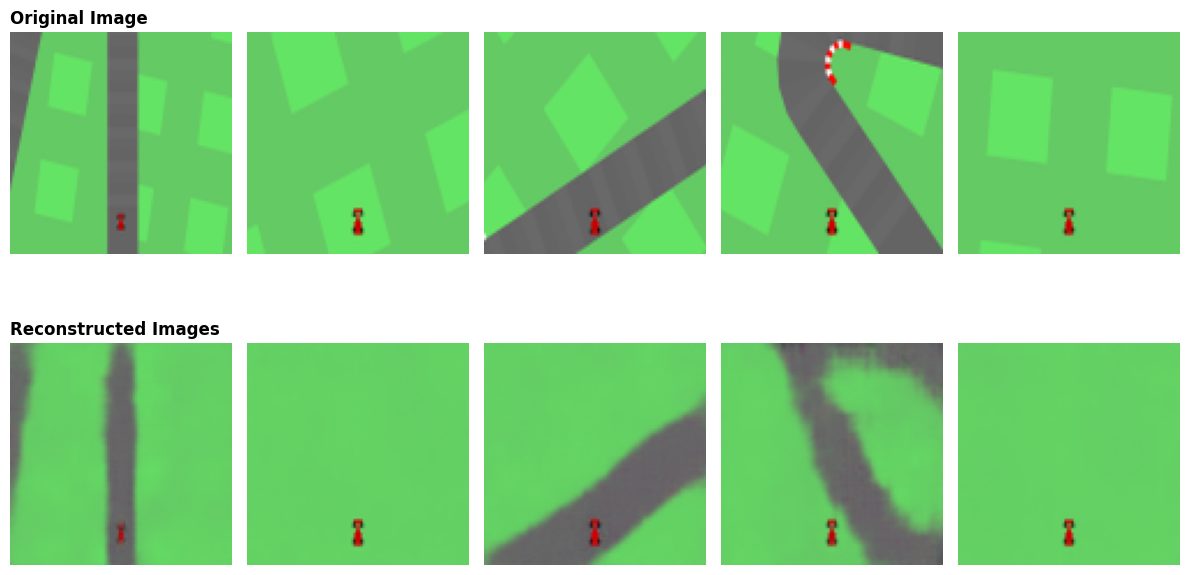

In [ ]:
from torch.utils.data import DataLoader
dataset = CarRacingDataset('car_racing_data_10k.h5')
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
test_vae(model, dataloader, n=5)

## **Interactive Environment Exploration**

This section allows interaction with the environment while visualizing the VAE's reconstruction capabilities in real-time.
 
- **Controls**: Arrow keys control the car (↑: accelerate, ↓: brake, ←/→: steer)
- **Visualization**: The display shows the original environment observation alongside the VAE's reconstruction
- **Video Recording**: Optional video recording of the interaction session


In [ ]:
import os
import gymnasium as gym
import pygame
import numpy as np
import torch
from torchvision import transforms
import cv2
from PIL import Image

# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Lambda(lambda img: img[:-12, :, :]),  # Crop the bottom status bar
    transforms.ToPILImage(),                         # Convert to PIL image
    transforms.Resize((96, 96), transforms.InterpolationMode.LANCZOS),  # High-quality resize
    transforms.ToTensor()                            # Convert to tensor and scale to [0,1]
])

def run_car_racing(env_name, vae_model, transform, device, scale=1, resolution=(96, 96), save_video=False, video_filename="car_racing_vae.avi"):
    """
    Run the Car Racing environment with real-time VAE reconstruction visualization.
    
    Args:
        env_name: Gymnasium environment name
        vae_model: Trained VAE model
        transform: Image preprocessing transformations
        device: Device to run model on (cuda/cpu)
        scale: Display scale factor
        resolution: Base resolution for visualization
        save_video: Whether to save a video recording
        video_filename: Output filename for video recording
    """
    os.makedirs('videos', exist_ok=True)
    video_filename = os.path.join('videos', video_filename)
    
    # Initialize pygame for visualization
    pygame.init()
    resolution = (resolution[0] * 2 * scale, resolution[1] * scale)
    screen = pygame.display.set_mode(resolution)
    clock = pygame.time.Clock()  

    action = np.zeros(3)  # Initialize action array [steering, gas, brake]

    def get_action(keys):
        """ Map keyboard input to actions """
        action[0] = -1.0 if keys[pygame.K_LEFT] else 1.0 if keys[pygame.K_RIGHT] else 0.0  # Steering
        action[1] = 1.0 if keys[pygame.K_UP] else 0.0    # Gas
        action[2] = 1.0 if keys[pygame.K_DOWN] else 0.0  # Brake
        return action

    # Create environment
    env = gym.make(env_name, render_mode='rgb_array')
    obs, _ = env.reset()
    
    # Video writer setup
    video_writer = None
    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        video_writer = cv2.VideoWriter(video_filename, fourcc, 30.0, (resolution[0], resolution[1]))

    running = True
    while running:
        # Process events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Get keyboard input and take environment step
        keys = pygame.key.get_pressed()
        action = get_action(keys)
        obs, reward, done, info, _ = env.step(action)

        # Preprocess and reconstruct with VAE
        obs_tensor = transform(obs).unsqueeze(0)
        with torch.no_grad():
            reconstructed, _, _ = vae_model(obs_tensor.to(device))

        # Prepare images for display
        reconstructed = (reconstructed.squeeze(0).permute(2, 1, 0).cpu().numpy() * 255).astype(np.uint8)
        obs = (obs_tensor.squeeze(0).permute(2, 1, 0).cpu().numpy() * 255).astype(np.uint8)

        # Combine original and reconstructed images side by side
        full_image = np.concatenate((obs, reconstructed), axis=0)
        full_image_resized = cv2.resize(full_image, (resolution[1], resolution[0]), interpolation=cv2.INTER_LINEAR)

        # Write frame to video if recording
        if save_video and video_writer is not None:
            video_writer.write(cv2.cvtColor(full_image_resized.transpose(1, 0, 2), cv2.COLOR_RGB2BGR))

        # Update display
        clock.tick(30)  # Cap at 30 FPS
        pygame.surfarray.blit_array(screen, full_image_resized)
        pygame.display.flip()

        # Reset environment if episode is done
        if done:
            obs, _ = env.reset()

    # Clean up
    if save_video and video_writer is not None:
        video_writer.release()

    pygame.quit()
    env.close()

In [ ]:
run_car_racing(env_name="CarRacing-v3", vae_model=model, transform=transform, 
              device=device, scale=6, save_video=False)

 ## **Interactive Latent Space Exploration**
 
 This section provides an interactive interface to explore the VAE's latent space and understand its learned representations.
 
 <img src="imgs/latent_exploration.png" width="600">
 
 ### Key Features:
 
 - **Latent Vector Manipulation**: Interactive sliders allow adjustment of individual dimensions in the latent space
 - **Real-time Image Generation**: The VAE decoder generates images from the modified latent vectors
 - **Random Sampling**: Generate random points in the latent space to explore its diversity
 - **Dimension Exploration**: A shift slider allows exploration of all latent dimensions (beyond those with dedicated sliders)


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox, Button, Output, HBox, IntSlider

LATENT_SIZE = 32
model.eval()

def generate_image(latent_vector):
    """
    Generate an image from a latent vector using the VAE decoder.
    
    Args:
        latent_vector: Vector in the latent space
    
    Returns:
        Generated image as numpy array
    """
    device = next(model.parameters()).device
    with torch.no_grad():
        latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)
        generated_image = model.decode(latent_tensor).squeeze(0).cpu().numpy()
        return generated_image

# Create sliders for latent space dimensions
num_sliders = 8
sliders = [FloatSlider(value=0.0, min=-3.0, max=3.0, step=0.1, description=f'Latent {i+1}') for i in range(num_sliders)]

output = Output()

def update_image(change):
    """
    Update the displayed image based on the current slider values.
    """
    latent_vector = np.zeros(LATENT_SIZE)
    for i, slider in enumerate(sliders):
        latent_vector[i + shift_slider.value] = slider.value
    generated_image = generate_image(latent_vector)
    
    with output:
        output.clear_output(wait=True)
        plt.figure(figsize=(5, 5))
        plt.imshow(generated_image.transpose(1, 2, 0))
        plt.axis('off')
        plt.title('Generated Image')
        plt.show()

def update_slider_labels(shift_value):
    """
    Update slider labels based on the shift value.
    """
    for i, slider in enumerate(sliders):
        slider.description = f'Latent {i + 1 + shift_value}'

# Link sliders to update function
for slider in sliders:
    slider.observe(update_image, 'value')

def generate_random_latent(button):
    """
    Generate a random latent vector and update sliders.
    """
    latent_vector = np.random.uniform(-3.0, 3.0, size=LATENT_SIZE)
    for i, slider in enumerate(sliders):
        slider.value = latent_vector[i + shift_slider.value]
    update_image(None)

# Create buttons
random_button = Button(description='Random Vector', 
                      tooltip='Generate random latent vector values',
                      style={'button_color': '#3498db'})
random_button.on_click(generate_random_latent)

reset_button = Button(description='Reset Sliders', 
                     tooltip='Reset all sliders to zero',
                     style={'button_color': '#e74c3c'})
def reset_sliders(button):
    """
    Reset all sliders to zero.
    """
    for slider in sliders:
        slider.value = 0.0
    update_image(None)
reset_button.on_click(reset_sliders)

# Shift slider to adjust which latent dimensions the other sliders modify
shift_slider = IntSlider(value=0, min=0, max=LATENT_SIZE - num_sliders, step=1, 
                        description='SHIFT',
                        tooltip='Shift which latent dimensions are controlled by sliders')
shift_slider.observe(lambda change: update_slider_labels(shift_slider.value), 'value')
shift_slider.observe(update_image, 'value')

# Create a vertical box for sliders, shift slider, and buttons with padding
slider_box = VBox(sliders + [shift_slider, random_button, reset_button], layout={'margin': '30px 0 0 0'})

# Create a horizontal box to hold the image output and sliders
layout = HBox([output, slider_box])

# Display the layout
display(layout)

# Generate an initial image and set initial slider labels
update_slider_labels(shift_slider.value)
update_image(None)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import os
import colorsys
from tqdm import tqdm

def create_enhanced_animation(
    model,
    output_path='enhanced_animation.mp4',
    fps=30,
    resolution=(640, 480),
    latent_size=32,
    amplitude=5.0  # Increased amplitude for more significant variations
):
    """
    Create an enhanced animation that produces more significant variations
    with an improved visualization of dimension changes.
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Create figure with two subplots - one for the image and one for visualization
    fig = plt.figure(figsize=(resolution[0]/100, resolution[1]/100), dpi=100)
    img_ax = plt.subplot2grid((4, 4), (0, 0), colspan=3, rowspan=3)  # Image takes most space
    viz_ax = plt.subplot2grid((4, 4), (0, 3), rowspan=3)  # Dimension visualization on right
    info_ax = plt.subplot2grid((4, 4), (3, 0), colspan=4)  # Info panel at bottom
    info_ax.axis('off')
    
    # Pre-compute which dimensions have the most impact on the output
    # We'll do this by testing each dimension individually
    print("Analyzing dimensions for impact...")
    dimension_impact = []
    
    base_latent = np.zeros(latent_size)
    base_image = None
    
    with torch.no_grad():
        # Generate base image with zero latent
        base_tensor = torch.tensor(base_latent, dtype=torch.float32).to(device).unsqueeze(0)
        base_image = model.decode(base_tensor).squeeze(0).cpu().numpy()
        
        # Test each dimension
        for dim in range(latent_size):
            test_latent = base_latent.copy()
            test_latent[dim] = amplitude  # Use maximum amplitude
            
            test_tensor = torch.tensor(test_latent, dtype=torch.float32).to(device).unsqueeze(0)
            test_image = model.decode(test_tensor).squeeze(0).cpu().numpy()
            
            # Calculate mean squared difference as impact measure
            impact = np.mean((test_image - base_image) ** 2)
            dimension_impact.append((dim, impact))
    
    # Sort dimensions by impact
    dimension_impact.sort(key=lambda x: x[1], reverse=True)
    top_dimensions = [dim for dim, _ in dimension_impact[:10]]  # Top 10 impactful dimensions
    
    print(f"Most impactful dimensions: {top_dimensions}")
    
    # Animation plan using most impactful dimensions:
    frames_per_segment = 60
    
    # Different animation segments
    segments = [
        # Sine waves on top dimensions
        {"type": "sine_wave", "dimensions": top_dimensions[:3], "frames": frames_per_segment},
        
        # Morphing between random latent vectors focused on top dimensions
        {"type": "random_morph", "dimensions": top_dimensions, "frames": frames_per_segment},
        
        # Circular pattern in pairs of top dimensions
        {"type": "circular", "dimensions": [top_dimensions[0], top_dimensions[1]], "frames": frames_per_segment},
        
        # Wave pattern across all top dimensions
        {"type": "wave", "dimensions": top_dimensions, "frames": frames_per_segment},
        
        # Counterpoise pattern (some dimensions increase while others decrease)
        {"type": "counterpoise", "dimensions": top_dimensions[:6], "frames": frames_per_segment}
    ]
    
    # Calculate total frames
    total_frames = sum(segment["frames"] for segment in segments)
    
    # Generate random vectors focused on top dimensions
    def generate_focused_random_vector():
        v = np.zeros(latent_size)
        for dim in top_dimensions:
            v[dim] = np.random.normal(0, amplitude/2)
        return v
    
    # Generate a few random vectors for morphing
    random_vectors = [generate_focused_random_vector() for _ in range(4)]
    
    # Add the first vector at the end to create a loop
    random_vectors.append(random_vectors[0].copy())
    
    # Function to update the dimension visualization
    def update_dimension_viz(latent_vector, title=None):
        viz_ax.clear()
        
        # Display top dimensions as vertical bars
        positions = np.arange(len(top_dimensions))
        values = [latent_vector[dim] for dim in top_dimensions]
        
        # Color bars based on value (blue for negative, red for positive)
        colors = []
        for val in values:
            if val > 0:
                # Red intensity based on positive value
                intensity = min(1.0, abs(val) / amplitude)
                colors.append((1.0, 0.4 * (1-intensity), 0.4 * (1-intensity)))
            else:
                # Blue intensity based on negative value
                intensity = min(1.0, abs(val) / amplitude)
                colors.append((0.4 * (1-intensity), 0.4 * (1-intensity), 1.0))
                
        viz_ax.barh(positions, values, color=colors)
        viz_ax.set_yticks(positions)
        viz_ax.set_yticklabels([f"D{dim}" for dim in top_dimensions])
        viz_ax.set_xlim(-amplitude, amplitude)
        viz_ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
        viz_ax.set_title("Top Dimensions" if not title else title)
    
    # Track which segment we're in
    current_frame = 0
    segment_start_frames = [0]
    for segment in segments:
        segment_start_frames.append(segment_start_frames[-1] + segment["frames"])
    total_frames = segment_start_frames[-1]  # Use the last element as total frames

    def generate_frame(frame_num):
        nonlocal current_frame
        current_frame = frame_num

        # Determine which segment we're in
        segment_idx = 0
        while segment_idx < len(segments) and frame_num >= segment_start_frames[segment_idx + 1]:
            segment_idx += 1

        segment = segments[segment_idx]
        segment_frame = frame_num - segment_start_frames[segment_idx]
        segment_progress = segment_frame / segment["frames"]
        
        # Initialize latent vector
        latent_vector = np.zeros(latent_size)
        segment_title = None
        
        if segment["type"] == "sine_wave":
            # Simple sine wave on top dimensions with different phases
            for i, dim in enumerate(segment["dimensions"]):
                phase = i * (2 * np.pi / len(segment["dimensions"]))
                latent_vector[dim] = amplitude * np.sin(segment_progress * 2 * np.pi + phase)
            segment_title = "Sine Wave Pattern"
            
        elif segment["type"] == "random_morph":
            # Morphing between random vectors
            morph_idx = int(segment_progress * (len(random_vectors) - 1))
            morph_progress = segment_progress * (len(random_vectors) - 1) - morph_idx
            
            start_vector = random_vectors[morph_idx]
            end_vector = random_vectors[morph_idx + 1]
            
            latent_vector = start_vector + morph_progress * (end_vector - start_vector)
            segment_title = f"Random Vector Morphing {morph_idx+1}/{len(random_vectors)-1}"
            
        elif segment["type"] == "circular":
            # Circular pattern in 2D space of top dimensions
            dim1, dim2 = segment["dimensions"][:2]
            latent_vector[dim1] = amplitude * np.cos(segment_progress * 2 * np.pi)
            latent_vector[dim2] = amplitude * np.sin(segment_progress * 2 * np.pi)
            segment_title = f"Circular Pattern D{dim1}-D{dim2}"
            
        elif segment["type"] == "wave":
            # Wave effect across dimensions
            for i, dim in enumerate(segment["dimensions"]):
                phase = i * (4 * np.pi / len(segment["dimensions"]))
                latent_vector[dim] = amplitude * np.sin(segment_progress * 6 * np.pi + phase)
            segment_title = "Wave Pattern"
            
        elif segment["type"] == "counterpoise":
            # Some dimensions increase while others decrease
            half = len(segment["dimensions"]) // 2
            for i, dim in enumerate(segment["dimensions"][:half]):
                latent_vector[dim] = amplitude * segment_progress
            for i, dim in enumerate(segment["dimensions"][half:]):
                latent_vector[dim] = amplitude * (1 - segment_progress)
            segment_title = "Counterpoise Pattern"
        
        # Generate image from latent vector
        with torch.no_grad():
            latent_tensor = torch.tensor(latent_vector, dtype=torch.float32).to(device).unsqueeze(0)
            generated_image = model.decode(latent_tensor).squeeze(0).cpu().numpy()
        
        # Display the image
        img_ax.clear()
        img_ax.imshow(generated_image.transpose(1, 2, 0))
        img_ax.axis('off')
        
        # Update dimension visualization
        update_dimension_viz(latent_vector, segment_title)
        
        # Update info panel
        info_ax.clear()
        info_ax.axis('off')
        active_dims = [dim for dim in segment["dimensions"] if abs(latent_vector[dim]) > 0.1]
        
        # Create textual description of what's happening
        description = f"{segment_title} - Frame {segment_frame+1}/{segment['frames']}\n"
        if active_dims:
            description += f"Active dimensions: " + ", ".join([f"D{dim}:{latent_vector[dim]:.2f}" for dim in active_dims[:5]])
            if len(active_dims) > 5:
                description += f" and {len(active_dims)-5} more..."
        
        info_ax.text(0.5, 0.5, description, ha='center', va='center', fontsize=9)
        
        # Very important to ensure figure is properly formatted
        fig.tight_layout()
        return [img_ax, viz_ax, info_ax]
    
    # Generate animation
    print(f"Generating enhanced animation with {total_frames} frames...")
    anim = animation.FuncAnimation(fig, generate_frame, frames=total_frames, blit=False)
    
    # Save the animation
    print(f"Saving animation to {output_path}...")
    writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='VAE Latent Space Explorer'), bitrate=5000)
    anim.save(output_path, writer=writer)
    
    plt.close()
    print(f"Enhanced animation saved to {output_path}")



# Create enhanced animation
create_enhanced_animation(
    model=model,
    output_path='videos/modern_latent_animation.mp4',
    fps=30,
    resolution=(800, 600),  # Larger resolution for better visibility
    amplitude=5.0  # Increased amplitude for more significant variations
)



Analyzing dimensions for impact...
Most impactful dimensions: [12, 7, 25, 13, 18, 24, 8, 31, 22, 26]
Generating enhanced animation with 300 frames...
Saving animation to latent_animation_enhanced.mp4...


Exception ignored in: <function CarRacingDataset.__del__ at 0x7b71a6b04360>
Traceback (most recent call last):
  File "/tmp/ipykernel_41828/3886461163.py", line 47, in __del__
AttributeError: 'CarRacingDataset' object has no attribute 'h5_file'


Enhanced animation saved to latent_animation_enhanced.mp4


 ## **Latent Space Visualization with UMAP**

 This section uses UMAP (Uniform Manifold Approximation and Projection) to visualize the high-dimensional latent space in 2D.
 
 UMAP is particularly effective at preserving both local and global structure of the data, making it ideal for understanding the organization of the latent space.


In [13]:
import torch
from tqdm import tqdm
LATENT_SIZE = 32
def get_latent_space(model,dataloader, batch, latent_size, max_batch):
    """Extracts latent vectors from dataset using the VAE model."""
    latent_space = []
    with torch.no_grad():
        for i in tqdm(range(max_batch), desc='Extracting latent space'):
            images, actions, rewards, dones = next(iter(dataloader))
            mu, logvar = model.encode(images.squeeze(0).to(device))
            z = model.reparameterize(mu, logvar)
            latent_space.append(z)
    latent_space = torch.stack(latent_space[:-1]).reshape((max_batch-1)*batch,latent_size)
    return latent_space.detach().cpu().numpy()


dataset = CarRacingDataset('car_racing_data_10k.h5')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
latent_space = get_latent_space(model, dataloader, 1000, LATENT_SIZE, max_batch=20)

Extracting latent space: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


In [14]:
import umap.umap_ as umap  

umap_model = umap.UMAP(n_components=2, min_dist=0.5)
latent_2d_umap = umap_model.fit_transform(latent_space)

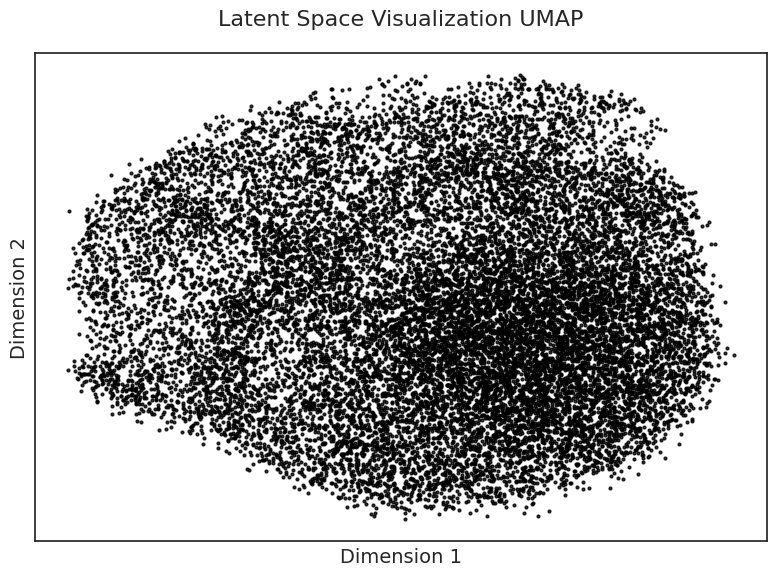

In [15]:
from utils import plot_latent_space

plot_latent_space(latent_2d_umap, 'UMAP')

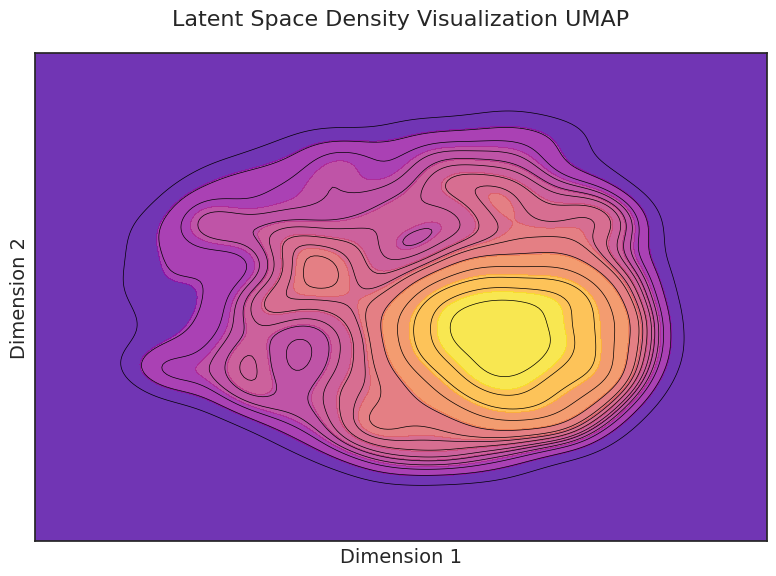

In [16]:
from utils import plot_latent_space_density

plot_latent_space_density(latent_2d_umap, 'UMAP')